<a href="https://colab.research.google.com/github/joshualin24/EEG_demo/blob/main/EEG_supervised_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

## Check GPU Status

In [ ]:
# import torch
# print("chech gpu status")
# print("CUDA available?", torch.cuda.is_available())

chech gpu status
CUDA available? False


## Clone Repository on Github and Import Packages

In [ ]:
# clone package repository
!git clone https://github.com/joshualin24/EEG_demo.git

Cloning into 'EEG_demo'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 184 (delta 87), reused 29 (delta 15), pack-reused 0
Receiving objects: 100% (184/184), 24.97 MiB | 5.02 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [ ]:
# insert the repository to Python path
import sys
path = '/content/EEG_demo'
if not path in sys.path:
    sys.path.append(path)

In [ ]:
# install packages requirements
# !pip install -r requirements.txt
!pip install -r EEG_demo/requirements.txt

     |████████████████████████████████| 582 kB 7.9 MB/s 
     |████████████████████████████████| 7.4 MB 58.3 MB/s 
     |████████████████████████████████| 134 kB 64.1 MB/s 
     |████████████████████████████████| 398 kB 47.7 MB/s 
     |████████████████████████████████| 596 kB 65.1 MB/s 
     |████████████████████████████████| 1.1 MB 46.3 MB/s 
     |████████████████████████████████| 144 kB 57.9 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 58.4 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is th

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EEG dataset

## Load dataset


In [ ]:
import os
import sklearn.model_selection

import torch
# from torch.autograd import Variable

import mne
from eegbci import DownstreamDataModule

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# mne.set_log_level(True)
mne.set_log_level('ERROR')

hyperparameters

In [ ]:
# Directory of downloaded data on Drive
DIR_DRIVE = 'drive/MyDrive/EEG_SupervisedLearning_Colab'
NAME_FOLDER = 'MNE-eegbci-data'

# Hyperparameter
TO_DOWNLOAD = False
DOWNSTREAM_BATCH_SIZE = 256  #64
DOWNSTREAM_NUM_STEPS = 640
TASKS = ['annotation', 'left/right', 'movement/imagery', 'fist/foot']

Download EEG data

In [ ]:
# download EEG data
if TO_DOWNLOAD or not os.path.exists(os.path.join(DIR_DRIVE,NAME_FOLDER)):
    case = TASKS[0]
    downstream_datamodule = DownstreamDataModule(case, DOWNSTREAM_BATCH_SIZE, DOWNSTREAM_NUM_STEPS,dir=DIR_DRIVE)
    downstream_datamodule.prepare_data()

Copy data from drive to local. (Increase loading speed)

In [ ]:
# copy EEG data from drive to local
import shutil

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

if not os.path.exists(NAME_FOLDER):
    copytree(os.path.join(DIR_DRIVE,NAME_FOLDER),NAME_FOLDER)

Setup dataloaders

In [ ]:
# downstream
case = TASKS[0]
downstream_datamodule = DownstreamDataModule(case, DOWNSTREAM_BATCH_SIZE, DOWNSTREAM_NUM_STEPS,dir='')

# setup dataloaders
downstream_datamodule.setup()

# train, validate, test dataloaders
train_data = downstream_datamodule.train_dataloader()
val_data = downstream_datamodule.val_dataloader()
test_data = downstream_datamodule.test_dataloader()

Do you want to set the path:
    /content
as the default EEGBCI dataset path in the mne-python config [y]/n? y


Preload datasets. (Increase load speed, but use more memory)

In [ ]:
# preload datasets
from torch.utils.data import Dataset, DataLoader

class PreloadedDataset(Dataset):
    def __init__(self,old_dataloader):
        for i,(x,y) in enumerate(old_dataloader):
            if i == 0:
                self.data = x
                self.label = y
            else:
                self.data = torch.cat((self.data,x),dim=0)
                self.label = torch.cat((self.label,y),dim=0)
    def __len__(self):
        return len(self.label)
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

def preload_data(old_dataloader, **kwargs):
    datasets = PreloadedDataset(old_dataloader)
    return DataLoader(datasets, batch_size=DOWNSTREAM_BATCH_SIZE, **kwargs)

train_data = preload_data(train_data,shuffle=True)
val_data = preload_data(val_data)
test_data = preload_data(test_data)

## Visualize data

In [ ]:
# Integer identifier of experimental tasks/events
EVENT_ID = {
    'rest/eye-open': 0,
    'rest/eye-closed': 1,
    'movement/left/fist': 2,
    'movement/right/fist': 3,
    'imagery/left/fist': 4,
    'imagery/right/fist': 5,
    'movement/both/fist': 6,
    'movement/both/foot': 7,
    'imagery/both/fist': 8,
    'imagery/both/foot': 9
}


Plot label distributions of test data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


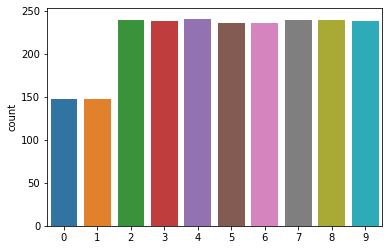

In [ ]:
# Test data
test_x, test_y = [],[]
for (x,y) in test_data:
    test_x.append(x)
    test_y.append(y)
test_x = torch.cat(test_x,0)
test_y = torch.cat(test_y,0)

# plot
sns.countplot(test_y.numpy())
plt.show()

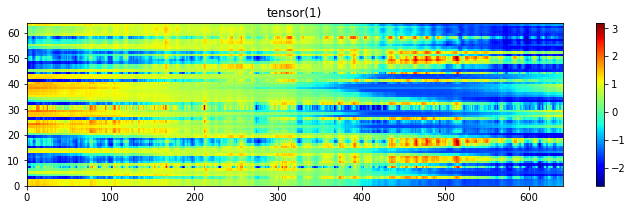

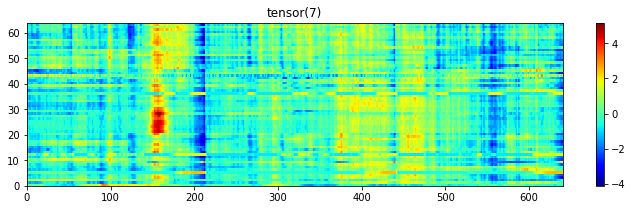

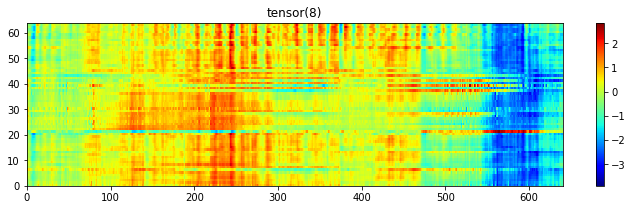

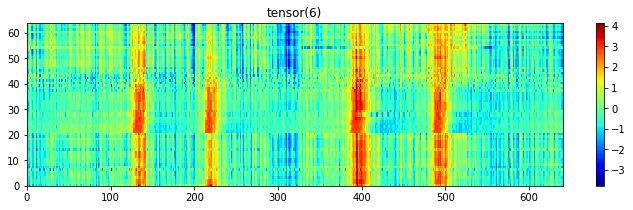

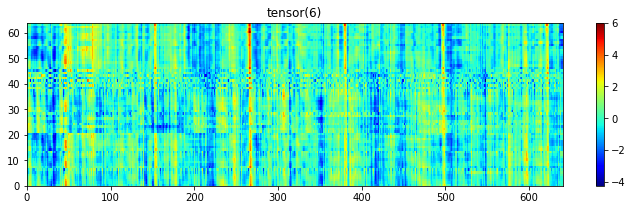

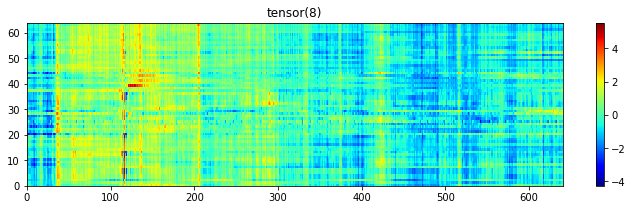

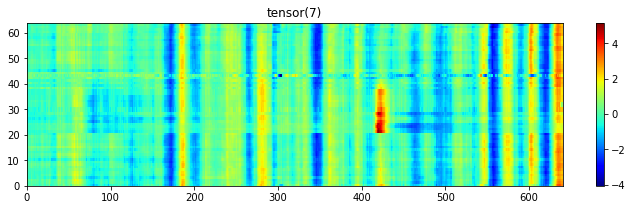

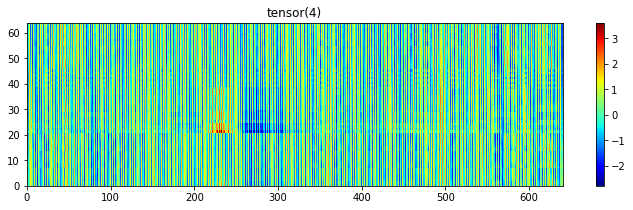

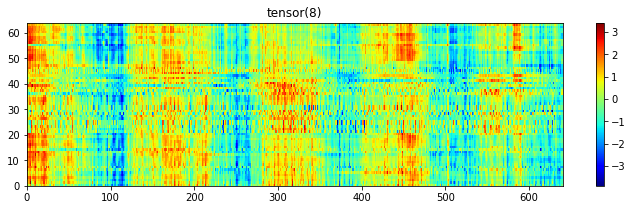

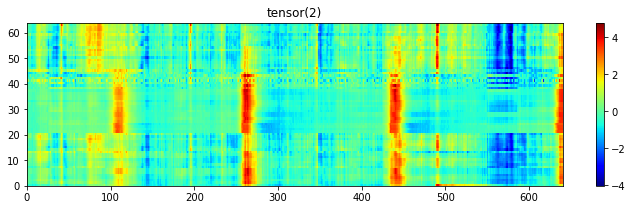

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(10):
    x = test_x[i]
    y = test_y[i]

    x_scaled = x -x.mean(dim=1,keepdim=True)
    x_scaled /= x_scaled.std(dim=1,keepdim=True)

    plt.figure(figsize=(12,3))
    plt.pcolor(x_scaled,cmap='jet')
    plt.colorbar()
    plt.title(y)
    plt.show()

## EEG Montage (WIP)

Get the positions of channels from EEG montage

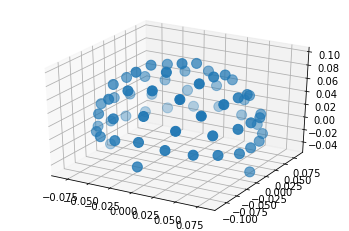

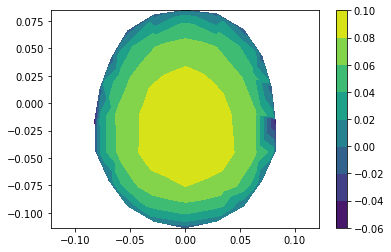

In [ ]:
import numpy as np
import mne

path = 'drive/MyDrive/EEG_SupervisedLearning_Colab/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf'
raw = mne.io.read_raw_edf(path)
chs = raw.ch_names
chs = [ch.replace('.','') for ch in chs]

montage = mne.channels.make_standard_montage('standard_1020')
ch_pos = montage.get_positions()['ch_pos']
ch_pos = {key.upper(): ch_pos[key] for key in ch_pos}

pos = [ch_pos[ch.upper()] for ch in chs]
pos = np.array(pos)

# plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pos[:,0],pos[:,1],pos[:,2],s=100)
plt.show()

plt.tricontourf(pos[:,0],pos[:,1],pos[:,2])
plt.axis('equal')
plt.colorbar()
plt.show()

Visualize data with channels' positions

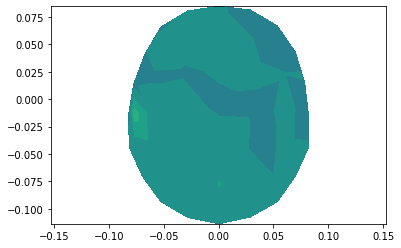

In [ ]:
# plot
x = test_x[0]
y = test_y[0]
V = np.linspace(x.mean()-2*x.std(),x.mean()+2*x.std(),16)
for c in x.transpose(0,1):
    # plot
    fig = plt.figure()
    plt.tricontourf(pos[:,0],pos[:,1],c,V,extend='both')
    plt.axis('equal')
    plt.show()
    break

Create an animation

In [ ]:
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

# setup figure
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)   
ax2 = plt.subplot(1,2,2)

# set up the subplots as needed
ax1.set_xlim(( 0, 640))            
ax1.set_ylim(( 0, 63))
ax1.set_xlabel('Time')
ax1.set_ylabel('Channels')
ax1.set_title(y)

ax2.set_xlim((-.1,.1))
ax2.set_ylim((-.15,.15))
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_aspect('equal')

# create objects that will change in the animation.
V = np.linspace(x.mean()-2*x.std(),x.mean()+2*x.std(),16)

pcm = ax1.pcolormesh(x,cmap='jet',vmin=V.min(),vmax=V.max())
line1, = ax1.plot([0,0],[0,63],'k-')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(pcm, cax=cax, orientation='vertical')

tricont = ax2.tricontourf(pos[:,0],pos[:,1],pos[:,2],V,cmap='jet')
txt_title = ax2.set_title('')

# don't show the plain background
plt.close()

# animation function. This is called sequentially
def drawframe(n):
    line1.set_data([n,n],[0,63])
    ax2.tricontourf(pos[:,0],pos[:,1],x[:,n],V,cmap='jet',extend='both')
    txt_title.set_text('Frame = {0:4d}'.format(n))
    return 

# animation
mult = 16

anim = animation.FuncAnimation(fig,lambda n: drawframe(mult*n), frames=640//mult, interval=100)
anim

# CNN Classification

## Import packages and setup hyperparameters

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

torch.manual_seed(1) ### import for reproducibility 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
### hyperparameter
EPOCH = 100
LR = 1e-2
WEIGHT_DECAY = 1e-1
EPOCH_EARLY_STOP = 10

TO_LOAD_MODEL = False
DIR_MODEL = 'drive/MyDrive/EEG_SupervisedLearning_Colab/CNN_model'

## Build Convolutional Neural Networks

Let's build a Convolutional Neural Networks with PyTorch!

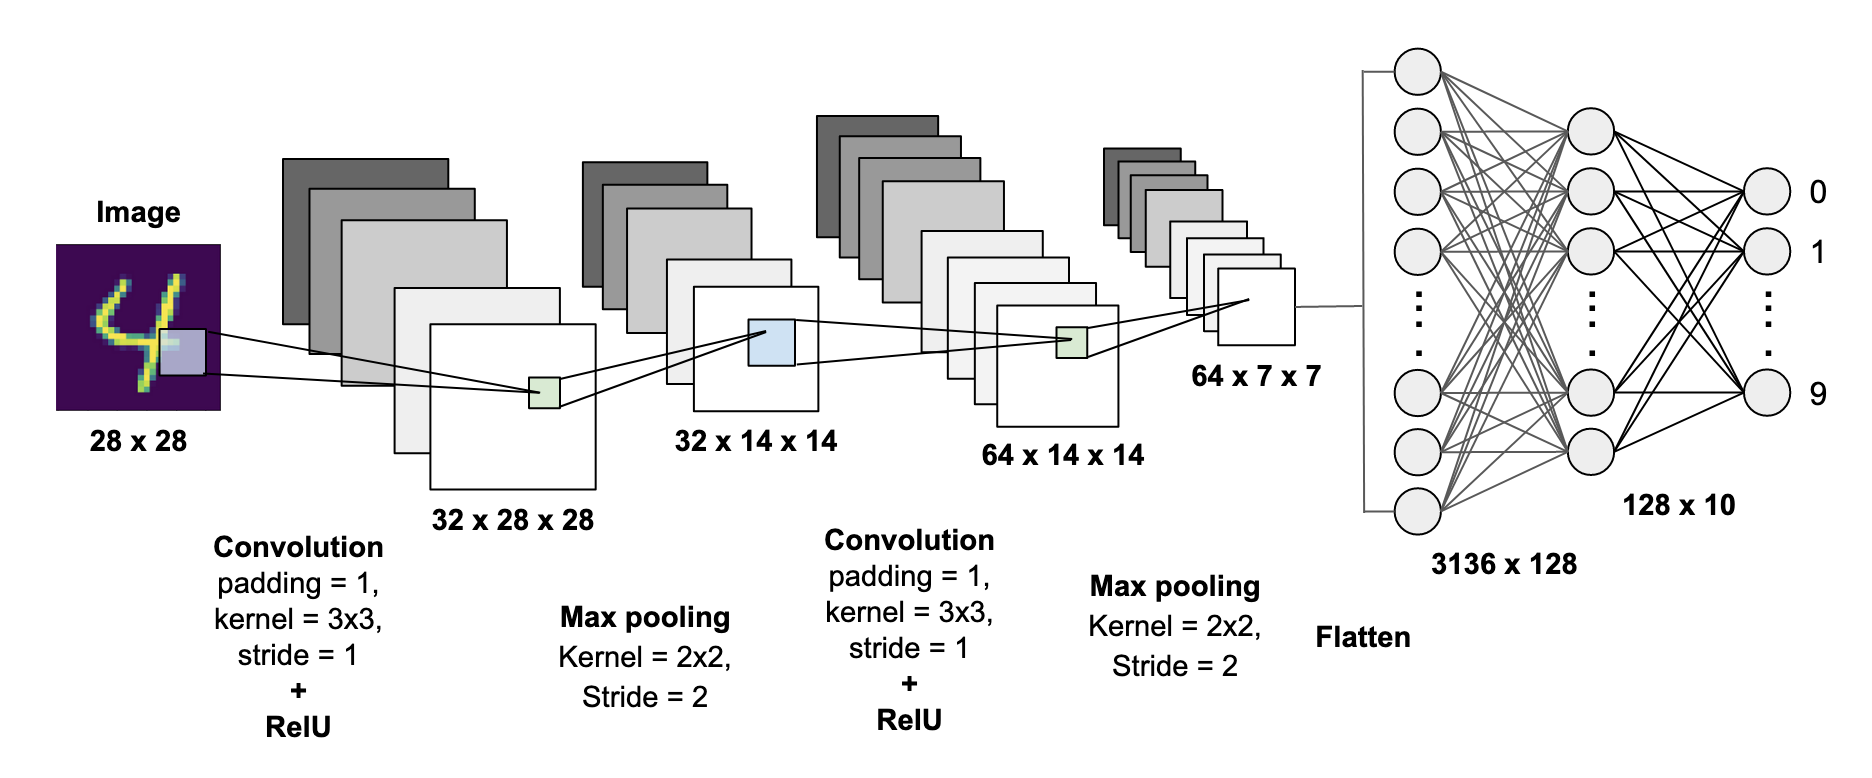

In [ ]:
### build a CNN here 
class CNN(nn.Module):
    def __init__(self, num_out=2):
        super(CNN, self).__init__()

        # convolution layer
        kwargs = dict()
        kwargs['kernel_size'] = 16+1
        kwargs['stride'] =4
        kwargs['padding'] = (kwargs['kernel_size']-1)//2
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=32, **kwargs),                      
            nn.ReLU(),)
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=16, **kwargs),    
            nn.ReLU(),)
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=16, out_channels=16, **kwargs),    
            nn.ReLU(),)
        
        # MLP layer
        self.out = nn.Sequential(
            nn.Linear(16*640//64, num_out),
            )

    def forward(self, x):
        # Fourier transformation
        # x = torch.fft.fft(x)
        # x = torch.abs(x)

        # convolution layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # MLP layers
        x = x.view(x.size(0), -1)
        output = self.out(x)

        return output

# # build a CNN here (Minimal model)
# class CNN(nn.Module):
#     def __init__(self, num_out=2):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=64, out_channels=16, kernel_size=16+1, stride=8, padding=8,),                      
#             nn.ReLU(),)

#         self.out = nn.Sequential(
#             nn.Linear(16*640//8, num_out),)

#     def forward(self, x):
#         # convolution layers
#         x = self.conv1(x)
        
#         # MLP layers
#         x = x.view(x.size(0), -1)
#         output = self.out(x)
        
#         return output

In [ ]:
path_model = DIR_MODEL +'_' +case.replace('/','_') +'.pkl'
if TO_LOAD_MODEL and os.path.exists(path_model):
    cnn = torch.load(path_model)
    print('The CNN model is loaded.')
else:
    if case == TASKS[0]:
        cnn = CNN(10)
    else:
        cnn = CNN(2)
    print('A CNN model is created.')

# !!!!!!!! Change in here !!!!!!!!! #
# cnn.cuda()      # Moves all model parameters and buffers to the GPU.

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_func = nn.CrossEntropyLoss()

A CNN model is created.


check our neural architecture


In [ ]:
from torchsummary import summary

summary(cnn, (64, 640), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 160]          34,848
              ReLU-2              [-1, 32, 160]               0
            Conv1d-3               [-1, 16, 40]           8,720
              ReLU-4               [-1, 16, 40]               0
            Conv1d-5               [-1, 16, 10]           4,368
              ReLU-6               [-1, 16, 10]               0
            Linear-7                   [-1, 10]           1,610
Total params: 49,546
Trainable params: 49,546
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.16
Forward/backward pass size (MB): 0.09
Params size (MB): 0.19
Estimated Total Size (MB): 0.44
----------------------------------------------------------------


## Train the CNN model

In [ ]:
def validation(cnn,val_data):
    with torch.no_grad():
        loss_val = []
        for step,(x,y) in enumerate(val_data):
            # b_x = x.cuda()    # Tensor in GPU
            # b_y = y.cuda()    # Tensor in GPU
            b_x = x
            b_y = y
            output = cnn(b_x)
            loss_val.append(loss_func(output,b_y).cpu().detach().numpy())

    return np.mean(loss_val)

def accuracy_test(cnn,test_data,softmax=False):
    with torch.no_grad():
        accuracy = []
        for (x,y) in test_data:
            # b_x = x.cuda()    # Tensor in GPU
            # b_y = y.cuda()    # Tensor in GPU
            b_x = x
            b_y = y
            output = cnn(b_x)

            # accuracy
            if softmax:
                # softmax
                pred_y = torch.softmax(output, 1)
                # pred_y = pred_y.cuda()    # Tensor in GPU
                accuracy.append(torch.take_along_dim(pred_y,b_y.view(-1,1),1))
            else:
                # argmax
                pred_y = torch.argmax(output,1)
                # pred_y = pred_y.cuda()    # Tensor in GPU
                accuracy.append((pred_y==b_y).type(torch.FloatTensor))
            
        return torch.cat(accuracy,0).mean().detach().numpy()

### plot the loss function
def plot_loss_history(losses_train,losses_val):
    plt.plot(np.arange(len(losses_train)),losses_train, label='train loss')
    plt.plot(np.arange(len(losses_val))*len(losses_train)/len(losses_val),losses_val, label='val loss')
    plt.legend()
    plt.show()

In [ ]:
# flushing denormal numbers (e.g. 1E-100 = 0)
torch.set_flush_denormal(True)

#Training starts here
losses_train = []
losses_val = []
t1 = time.time()
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_data):
        # b_x = x.cuda()    # Tensor in GPU
        # b_y = y.cuda()    # Tensor in GPU
        b_x = x
        b_y = y

        optimizer.zero_grad()
        output = cnn(b_x)
        loss = loss_func(output, b_y)
        losses_train.append(loss.cpu().detach().numpy())
        loss.backward()
        optimizer.step()
        
        # # print
        # if step % 10 == 0:
        #     print(f'Epoch:{epoch}, Step:{step}, Loss:{losses_train[-1]}')

    # validation and testing
    loss_val = validation(cnn,val_data)
    losses_val.append(loss_val)
    accuracy = accuracy_test(cnn,test_data,softmax=False)
    print('Epoch:%3d' % epoch, '|Step: %4d' % step, \
        '| train loss: %.4f' % loss, '| val loss: %.4f' % loss_val, \
        '| test accuracy: %.4f' % accuracy)

    # save best model
    if loss_val == np.min(losses_val):
        torch.save(cnn,path_model)

    # print runtime
    t2 = time.time()
    print("runtime: %.3f sec" % (t2- t1))
    t1 = t2

    # early stop
    if np.min(losses_val) != np.min(losses_val[-EPOCH_EARLY_STOP:]):
        break

Epoch:  0 |Step:   68 | train loss: 2.2297 | val loss: 2.2308 | test accuracy: 0.1502
runtime: 24.100 sec
Epoch:  1 |Step:   68 | train loss: 2.1273 | val loss: 2.1426 | test accuracy: 0.1810
runtime: 22.186 sec
Epoch:  2 |Step:   68 | train loss: 2.0745 | val loss: 2.0996 | test accuracy: 0.2015
runtime: 21.970 sec
Epoch:  3 |Step:   68 | train loss: 2.1000 | val loss: 2.0740 | test accuracy: 0.2273
runtime: 22.019 sec
Epoch:  4 |Step:   68 | train loss: 2.0960 | val loss: 2.0646 | test accuracy: 0.2291
runtime: 22.076 sec
Epoch:  5 |Step:   68 | train loss: 2.0077 | val loss: 2.0452 | test accuracy: 0.2250
runtime: 21.989 sec
Epoch:  6 |Step:   68 | train loss: 2.0500 | val loss: 2.0446 | test accuracy: 0.2495
runtime: 21.997 sec
Epoch:  7 |Step:   68 | train loss: 2.0120 | val loss: 2.0407 | test accuracy: 0.2241
runtime: 21.997 sec
Epoch:  8 |Step:   68 | train loss: 2.0412 | val loss: 2.0354 | test accuracy: 0.2450
runtime: 22.025 sec
Epoch:  9 |Step:   68 | train loss: 1.9744 | v

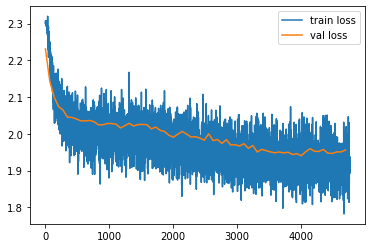

In [ ]:
# plot loss history
plot_loss_history(losses_train,losses_val)

## Visualize prediction

In [ ]:
# accuracy
accuracy = accuracy_test(cnn,test_data,softmax=False)
print('Accuracy: ', accuracy)

Accuracy:  0.27676952


In [ ]:
# confusion_matrix
confusion_matrix = np.zeros((10,10),dtype=int)
with torch.no_grad():
    for x,y in test_data:
        test_output = cnn(x)
        pred_y = torch.argmax(test_output, 1).squeeze().detach()
        for p,t in zip(pred_y,y):
            confusion_matrix[t.long(),p.long()]+=1
        # break

confusion_matrix

array([[ 29,  19,   5,   7,  22,   9,   7,   1,  37,  12],
       [  7,  55,   4,  16,  19,  14,   4,   1,  16,  12],
       [  2,  13,  20,   9, 125,  11,   7,   1,  43,   9],
       [  8,  12,   2,  47,  10, 100,   1,   2,  44,  12],
       [  3,  16,  10,   8, 131,   4,   4,   5,  44,  16],
       [  7,  11,   2,  35,  14,  98,   7,   5,  35,  22],
       [ 12,  10,   5,  12,  22,  12,  20,   3, 123,  17],
       [ 11,   5,   3,  11,  26,  15,  12,  11,  75,  71],
       [  7,   9,   5,  14,  23,  16,  11,  10, 122,  22],
       [ 11,  15,   5,   6,  32,  19,   4,  13,  56,  77]])

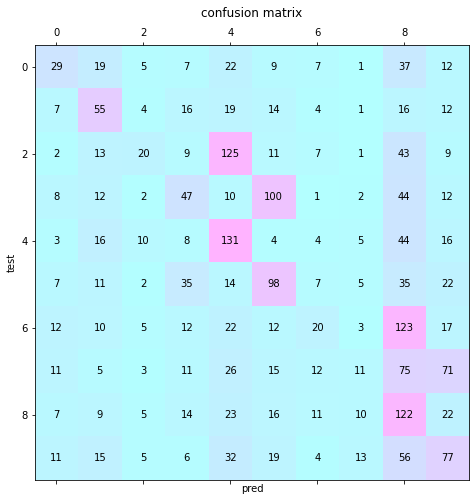

In [ ]:
#plot
cm = confusion_matrix+1
cm = cm/cm.sum(axis=1)
fig, ax = plt.subplots(figsize=(10,8))
ax.matshow(cm,cmap='cool',alpha=0.3)
for (i, j), z in np.ndenumerate(confusion_matrix):
    ax.text(j, i, '{:.0f}'.format(z), ha='center', va='center')
plt.xlabel('pred')
plt.ylabel('test')
plt.title('confusion matrix')
plt.show()

In [ ]:
# Integer identifier of experimental tasks/events
EVENT_ID = {
    'rest/eye-open': 0,
    'rest/eye-closed': 1,
    'movement/left/fist': 2,
    'movement/right/fist': 3,
    'imagery/left/fist': 4,
    'imagery/right/fist': 5,
    'movement/both/fist': 6,
    'movement/both/foot': 7,
    'imagery/both/fist': 8,
    'imagery/both/foot': 9
}